# **chest x-ray Partie 2**
#**division des données en 3 classes**


## importation des differentes librairies

In [ ]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import PIL.Image


In [ ]:
import random
import pathlib     
import matplotlib as mat
import matplotlib.pyplot as plt  
import seaborn as sns
%matplotlib inline

In [ ]:
pd.options.display.max_colwidth = 100

In [ ]:
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
print(tf.version.VERSION)

2.6.0


In [ ]:
import glob
import cv2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [ ]:
!pwd

/content


In [ ]:
!ls


sample_data


## Prétraitement des données

### Téléchargement des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
main_path = "./drive/MyDrive/chest_xray"
train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia_bac = glob.glob(train_path+"/PNEUMONIA/BACTERIA*.jpeg")
train_pneumonia_vir = glob.glob(train_path+"/PNEUMONIA/VIRUS*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia_bac = glob.glob(test_path+"/PNEUMONIA/BACTERIA*.jpeg")
test_pneumonia_vir = glob.glob(test_path+"/PNEUMONIA/VIRUS*.jpeg")

In [ ]:
#on cree la liste train normale a laquelle on ajoute les listes train pneumo bacteries et virus ils vont former la liste train
train_list_normal = [x for x in train_normal]
train_list_bac=[x for x in train_pneumonia_bac]
train_list_vir=[x for x in train_pneumonia_vir]
train_list=[]
train_list.extend(train_list_normal)
train_list.extend(train_list_bac)
train_list.extend(train_list_vir)

#on contruit le dafaframe de train en utilisant 0 pour l classe normales, 
#1 pour la penumonia bacterie et 2 pour la pneuminia virus. 
#cela nous permetara de faire le to_catagorical apres.
train_df = pd.DataFrame(np.concatenate([['0']*len(train_normal) , ['1']*len(train_pneumonia_bac),
                                       ['2']*len(train_pneumonia_vir)]), columns = ['class'])

train_df['image'] = [x for x in train_list]

#de meme pour test
test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia_bac])
test_list.extend([x for x in test_pneumonia_vir])

df_test = pd.DataFrame(np.concatenate([[int('0')]*len(test_normal) , ['1']*len(test_pneumonia_bac),
                                       [int('2')]*len(test_pneumonia_vir)]), columns = ['class'])
df_test['image'] = [x for x in test_list]


In [ ]:
df_test

,class,image
0,0,./drive/MyDrive/chest_xray/test/NORMAL/NORMAL-1110860-0001.jpeg
1,0,./drive/MyDrive/chest_xray/test/NORMAL/NORMAL-11419-0001.jpeg
2,0,./drive/MyDrive/chest_xray/test/NORMAL/NORMAL-115218-0001.jpeg
3,0,./drive/MyDrive/chest_xray/test/NORMAL/NORMAL-1160949-0001.jpeg
4,0,./drive/MyDrive/chest_xray/test/NORMAL/NORMAL-1049278-0001.jpeg
...,...,...
619,2,./drive/MyDrive/chest_xray/test/PNEUMONIA/VIRUS-8507816-0001.jpeg
620,2,./drive/MyDrive/chest_xray/test/PNEUMONIA/VIRUS-9018258-0001.jpeg
621,2,./drive/MyDrive/chest_xray/test/PNEUMONIA/VIRUS-874167-0001.jpeg
622,2,./drive/MyDrive/chest_xray/test/PNEUMONIA/VIRUS-9968655-0001.jpeg


In [ ]:
len(train_list_normal), len(train_list_bac),len(train_list_vir)

(1349, 2538, 1345)

### Lecture des images

In [ ]:
def img_to_array(data, x):
  for i in data:
    img=cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img_np=cv2.resize(img, dsize=(IMG_SIZE,IMG_SIZE))
    x.append(img_np)

In [ ]:
category_list=['NORMAL', 'BACTERIA', 'VIRUS']
train_x=[]
x_test=[]
img_to_array(train_df['image'], train_x)
img_to_array(df_test['image'], x_test)


In [ ]:
#on met le to_catagorique pour avoir un y en sortie 
#qui sera une matrice 3 colonnes 
#on aura le 1 a la position de la classe
train_y=train_df['class']
train_y=keras.utils.to_categorical(train_y,3)

y_test=df_test['class']
y_test=keras.utils.to_categorical(y_test,3)


In [ ]:
#on saugarde les x_train et y_train ainsi que les x_test et y_test 
#cela nous facilitera la travail apres
np.savez('train_array_c3f', x_train= train_x, y_train=train_y)
np.savez('test_array_c3f', x_test=x_test, y_test=y_test)

In [ ]:
!pwd

/content


In [ ]:
!cp train_array_c3f.npz ./drive/MyDrive/
!cp test_array_c3f.npz ./drive/MyDrive/

In [ ]:
train_numpy=np.load('./drive/MyDrive/train_array_c3f.npz')
test_numpy=np.load('./drive/MyDrive/test_array_c3f.npz')
train_numpy.files , test_numpy.files 

(['x_train', 'y_train'], ['x_test', 'y_test'])

In [ ]:
train_x=train_numpy['x_train']
train_y=train_numpy['y_train']
x_test=test_numpy['x_test']
y_test=test_numpy['y_test']

### Division de groupe de la validation

In [ ]:
#division egale au niveau des 3 classes
df_val=train_df.groupby("class").sample(350)

In [ ]:
df_train=train_df
df_train=train_df.drop(df_val.index)
df_train

,class,image
0,0,./drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3411116-0001.jpeg
1,0,./drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3342765-0002.jpeg
2,0,./drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3333785-0001.jpeg
3,0,./drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3360834-0001.jpeg
4,0,./drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3487615-0001.jpeg
...,...,...
5227,2,./drive/MyDrive/chest_xray/train/PNEUMONIA/VIRUS-3745681-0002.jpeg
5228,2,./drive/MyDrive/chest_xray/train/PNEUMONIA/VIRUS-3973430-0001.jpeg
5229,2,./drive/MyDrive/chest_xray/train/PNEUMONIA/VIRUS-4170270-0004.jpeg
5230,2,./drive/MyDrive/chest_xray/train/PNEUMONIA/VIRUS-3595250-0003.jpeg


In [ ]:
len(df_val), len(df_train), len(train_x)

(1050, 4182, 5232)

In [ ]:
x_train=[]
y_train=[]
for i in df_train.index:
  x_train.append(train_x[i])
  y_train.append(train_y[i])


x_val=[]
y_val=[]
for i in df_val.index:
  x_val.append(train_x[i])
  y_val.append(train_y[i])

### Ajustement des données

In [ ]:
#on fait les derniers ajustement sur les données 
#ici on les transforme en numpy_array
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

In [ ]:
x_train=(np.array(x_train).reshape(-1,IMG_SIZE,IMG_SIZE,1))
x_test=(np.array(x_test).reshape(-1,IMG_SIZE,IMG_SIZE,1))
x_val=(np.array(x_val).reshape(-1,IMG_SIZE,IMG_SIZE,1))


In [ ]:
y_train.shape, x_train.shape, y_val.shape, x_val.shape

((4182, 3), (4182, 224, 224, 1), (1050, 3), (1050, 224, 224, 1))

In [ ]:
x_train=x_train/255
x_test=x_test/255
x_val=x_val/255

In [ ]:
y_train.shape, x_train.shape, y_val.shape, x_val.shape

((4182, 3), (4182, 224, 224, 1), (1050, 3), (1050, 224, 224, 1))

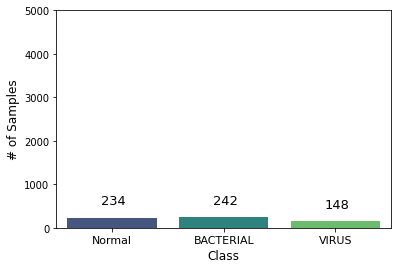

In [ ]:
#test graph
plt.figure(figsize=(6,4))
ax = sns.countplot(x='class', data=df_test, palette="viridis") 

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1,2], ['Normal', 'BACTERIAL', 'VIRUS'], fontsize = 11)

#ajoute les numero obtenus
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

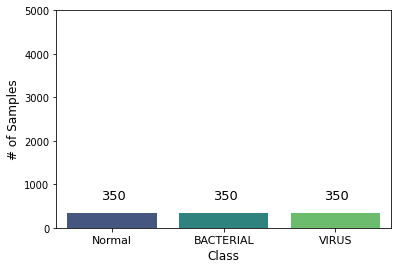

In [ ]:
#validation graph
plt.figure(figsize=(6,4))
ax = sns.countplot(x='class', data=df_val, palette="viridis") 

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1,2], ['Normal', 'BACTERIAL', 'VIRUS'], fontsize = 11)

#ajoute les numero obtenus
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

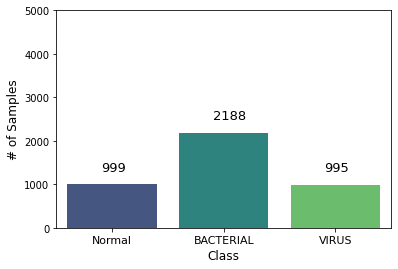

In [ ]:
#train graph
plt.figure(figsize=(6,4))
ax = sns.countplot(x='class', data=df_train, palette="viridis")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1,2], ['Normal', 'BACTERIAL', 'VIRUS'], fontsize = 11)

#ajoute les numero obtenus
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

### Preparation des differents parametre a utiliser pour les modéles

In [ ]:
#on cherche a avoir le weight à utiliser dans les modéles
count_train=df_train.groupby('class').count()
count_test=df_test.groupby('class').count()
count_val=df_val.groupby('class').count()

In [ ]:
count_train, count_test, count_val

(       image
 class       
 0        999
 1       2188
 2        995,        image
 class       
 0        234
 1        242
 2        148,        image
 class       
 0        350
 1        350
 2        350)

In [ ]:
#on obtient le nombre de chaque classes
count_train_normal=count_train['image']['0']
count_train_pneumo_bac=count_train['image']['1']
count_train_pneumo_vir=count_train['image']['2']

In [ ]:
wnormal=len(df_train)/(3*count_train_normal)
wbac=len(df_train)/(3*count_train_pneumo_bac)
wvir=len(df_train)/(3*count_train_pneumo_vir)

In [ ]:
#les weight a utiliser
class_weight={
    0: wnormal,
    1: wbac,
    2: wvir
}

In [ ]:
#initilisation des paramétres de la data augmentation
datagen = ImageDataGenerator(
                                  zoom_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1
                                  )
datagen.fit(x_train)


In [ ]:
#initilisation des paramétres du callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

In [ ]:
!pwd

/content


## Les modèles et l'appentissage

### modèle 1

In [ ]:
def get_model_s():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

       # Block One
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)


  
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)

    
    #Output
    output = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:
keras.backend.clear_session()

model_s = get_model_s()
model_s.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='categorical_accuracy')

model_s.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 8)       0         
_________________________________________________________________
flatten (Flatten)            (None, 98568)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 295707    
Total params: 295,787
Trainable params: 295,787
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_s = model_s.fit(x_train, y_train,
          batch_size = BATCH, epochs = 10,
          validation_data=(x_val, y_val), class_weight= class_weight);

Epoch 1/10
131/131 [==============================] - 34s 30ms/step - loss: 1.3429 - categorical_accuracy: 0.6239 - val_loss: 0.6569 - val_categorical_accuracy: 0.7105
Epoch 2/10
131/131 [==============================] - 3s 25ms/step - loss: 0.5410 - categorical_accuracy: 0.7549 - val_loss: 0.6168 - val_categorical_accuracy: 0.7238
Epoch 3/10
131/131 [==============================] - 3s 25ms/step - loss: 0.4851 - categorical_accuracy: 0.7798 - val_loss: 0.5031 - val_categorical_accuracy: 0.7714
Epoch 4/10
131/131 [==============================] - 3s 25ms/step - loss: 0.4212 - categorical_accuracy: 0.8094 - val_loss: 0.4768 - val_categorical_accuracy: 0.7962
Epoch 5/10
131/131 [==============================] - 3s 25ms/step - loss: 0.3925 - categorical_accuracy: 0.8204 - val_loss: 0.4672 - val_categorical_accuracy: 0.7857
Epoch 6/10
131/131 [==============================] - 3s 25ms/step - loss: 0.3709 - categorical_accuracy: 0.8309 - val_loss: 0.4722 - val_categorical_accuracy: 0.78

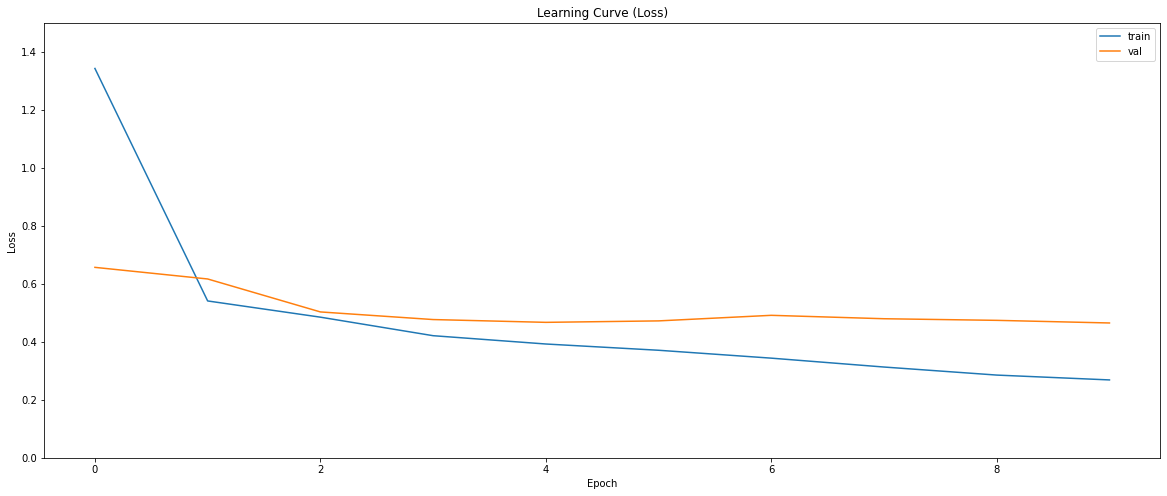

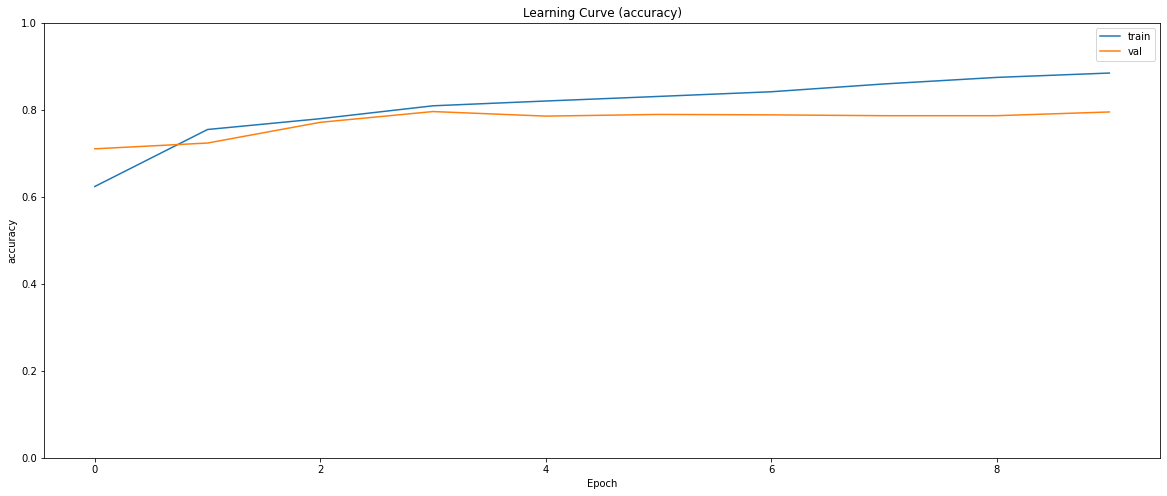

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s.epoch, y = history_s.history['loss'])
sns.lineplot(x = history_s.epoch, y = history_s.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.5)
ax.legend(['train', 'val'], loc='best')
plt.show()


fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s.epoch, y = history_s.history['categorical_accuracy'])
sns.lineplot(x = history_s.epoch, y = history_s.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()


In [ ]:
score = model_s.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5531876087188721
Test accuracy: 0.8237179517745972


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_s.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[170,  19,  45],
       [  2, 230,  10],
       [  2,  32, 114]])

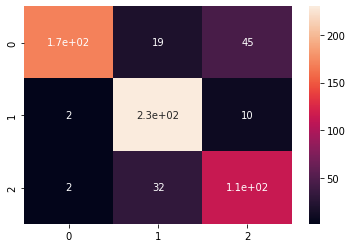

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modéle 2

In [ ]:
keras.backend.clear_session()
#modele 1 avec data augmentation 
model_sd = get_model_s()
model_sd.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='categorical_accuracy')

model_sd.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 8)       0         
_________________________________________________________________
flatten (Flatten)            (None, 98568)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 295707    
Total params: 295,787
Trainable params: 295,787
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_sd = model_sd.fit(datagen.flow(x_train, y_train),
          batch_size = BATCH, epochs = 10,
          validation_data=datagen.flow(x_val, y_val), class_weight= class_weight);

Epoch 1/10
131/131 [==============================] - 22s 162ms/step - loss: 1.5959 - categorical_accuracy: 0.5459 - val_loss: 0.7987 - val_categorical_accuracy: 0.6610
Epoch 2/10
131/131 [==============================] - 21s 161ms/step - loss: 0.7513 - categorical_accuracy: 0.6538 - val_loss: 0.7588 - val_categorical_accuracy: 0.6210
Epoch 3/10
131/131 [==============================] - 21s 162ms/step - loss: 0.6833 - categorical_accuracy: 0.6779 - val_loss: 0.6501 - val_categorical_accuracy: 0.7067
Epoch 4/10
131/131 [==============================] - 21s 162ms/step - loss: 0.6650 - categorical_accuracy: 0.6903 - val_loss: 0.6636 - val_categorical_accuracy: 0.6952
Epoch 5/10
131/131 [==============================] - 21s 162ms/step - loss: 0.6595 - categorical_accuracy: 0.6946 - val_loss: 0.6321 - val_categorical_accuracy: 0.7038
Epoch 6/10
131/131 [==============================] - 21s 162ms/step - loss: 0.6411 - categorical_accuracy: 0.6930 - val_loss: 0.6170 - val_categorical_acc

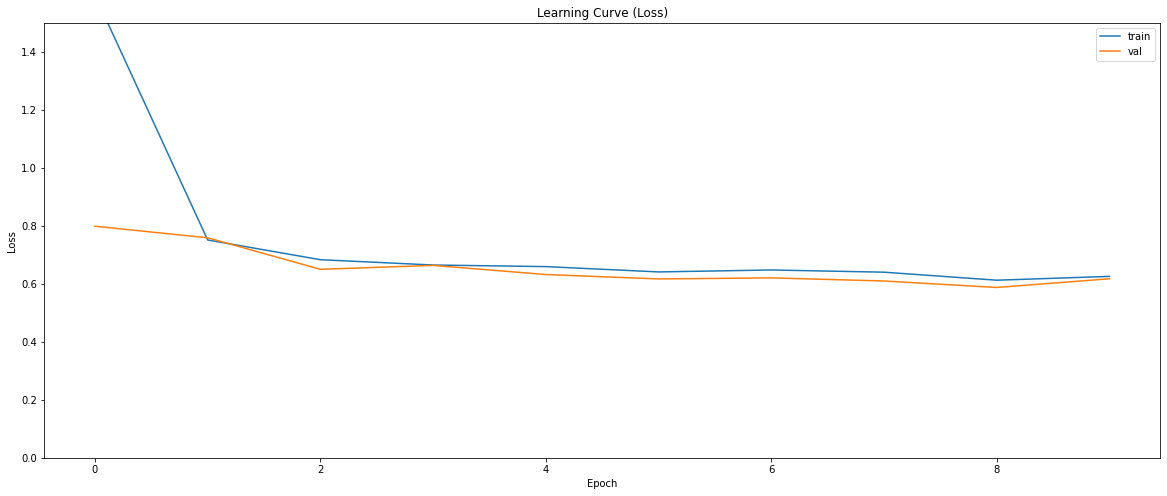

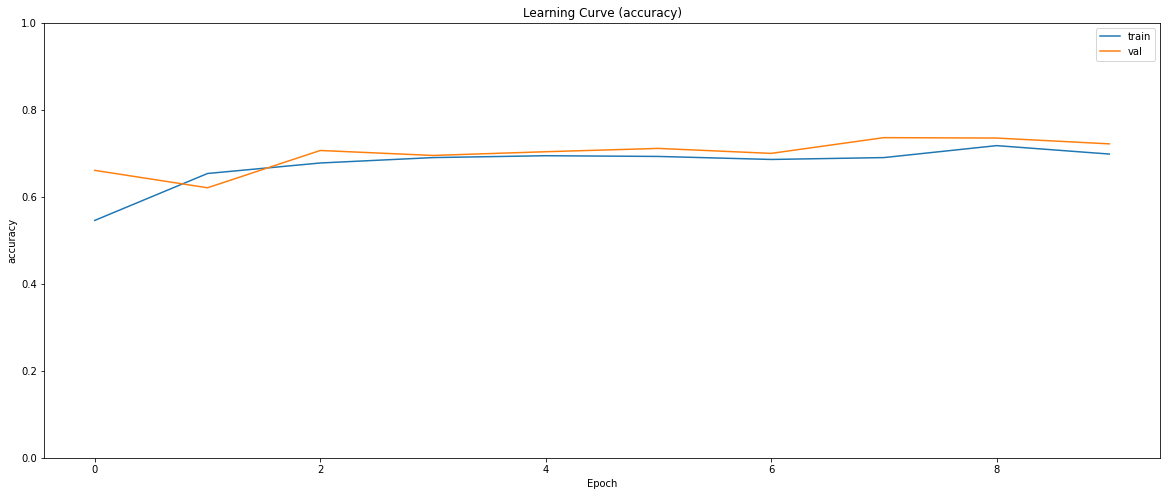

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_sd.epoch, y = history_sd.history['loss'])
sns.lineplot(x = history_sd.epoch, y = history_sd.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_sd.epoch, y = history_sd.history['categorical_accuracy'])
sns.lineplot(x = history_sd.epoch, y = history_sd.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_sd.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5178295373916626
Test accuracy: 0.8125


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_sd.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[178,  16,  40],
       [ 10, 218,  14],
       [  4,  33, 111]])

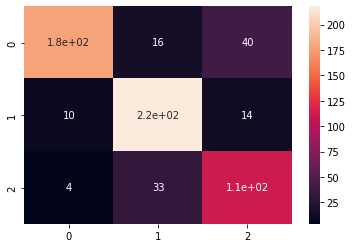

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modéle 3

In [ ]:
keras.backend.clear_session()
#modele avec data augmentation et learning rate=0.00001
model_sd2 = get_model_s()
model_sd2.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.00001), metrics='categorical_accuracy')

model_sd2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 8)       0         
_________________________________________________________________
flatten (Flatten)            (None, 98568)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 295707    
Total params: 295,787
Trainable params: 295,787
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_sd2 = model_sd2.fit(datagen.flow(x_train, y_train),
          batch_size = BATCH, epochs = 10,
          validation_data=datagen.flow(x_val, y_val), class_weight= class_weight);

Epoch 1/10
131/131 [==============================] - 22s 162ms/step - loss: 1.0630 - categorical_accuracy: 0.4393 - val_loss: 1.0126 - val_categorical_accuracy: 0.5248
Epoch 2/10
131/131 [==============================] - 21s 159ms/step - loss: 0.9914 - categorical_accuracy: 0.5536 - val_loss: 0.9868 - val_categorical_accuracy: 0.5381
Epoch 3/10
131/131 [==============================] - 21s 159ms/step - loss: 0.9467 - categorical_accuracy: 0.5933 - val_loss: 0.9412 - val_categorical_accuracy: 0.5438
Epoch 4/10
131/131 [==============================] - 21s 162ms/step - loss: 0.9118 - categorical_accuracy: 0.6076 - val_loss: 0.9049 - val_categorical_accuracy: 0.5924
Epoch 5/10
131/131 [==============================] - 21s 162ms/step - loss: 0.8853 - categorical_accuracy: 0.6255 - val_loss: 0.8930 - val_categorical_accuracy: 0.6133
Epoch 6/10
131/131 [==============================] - 21s 163ms/step - loss: 0.8542 - categorical_accuracy: 0.6461 - val_loss: 0.8706 - val_categorical_acc

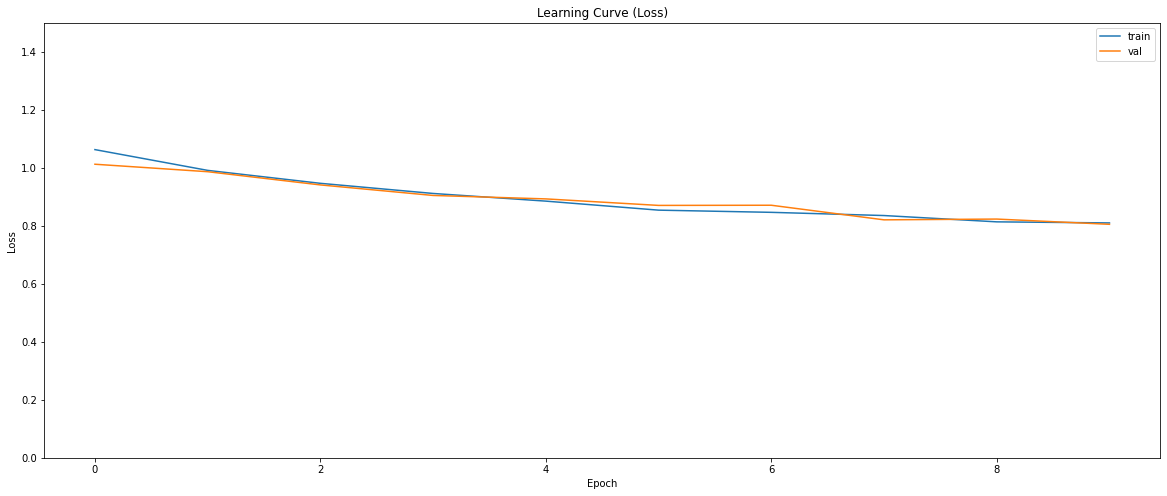

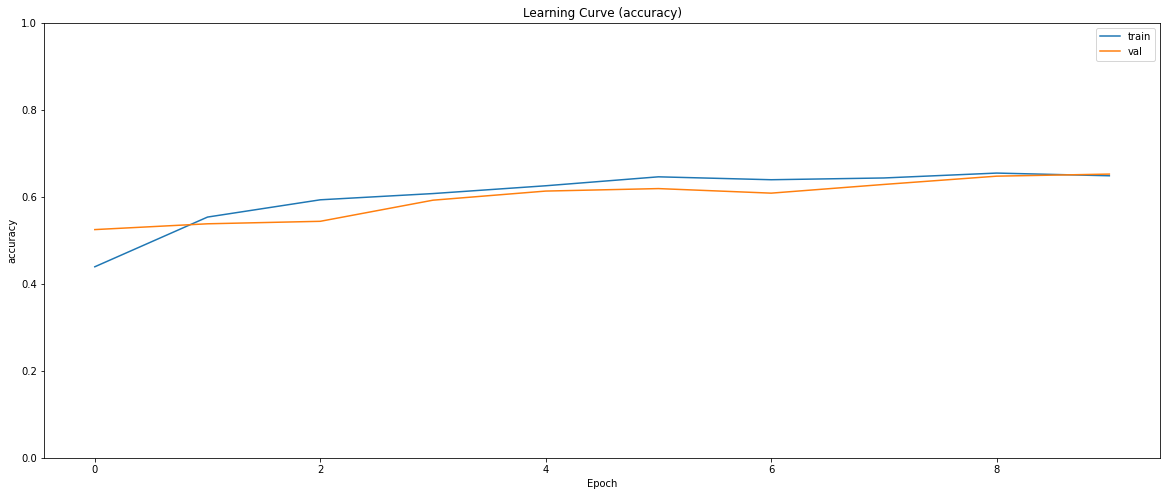

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_sd2.epoch, y = history_sd2.history['loss'])
sns.lineplot(x = history_sd2.epoch, y = history_sd2.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_sd2.epoch, y = history_sd2.history['categorical_accuracy'])
sns.lineplot(x = history_sd2.epoch, y = history_sd2.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_sd2.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6554111838340759
Test accuracy: 0.7772436141967773


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_sd2.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[212,   8,  14],
       [ 16, 200,  26],
       [ 52,  23,  73]])

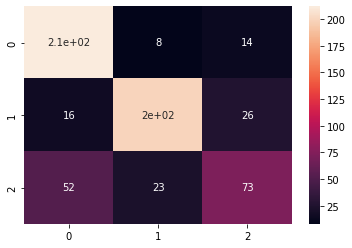

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modéle 4

In [ ]:
def get_model_s2():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

       # Block One
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    



    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    
    #Output
    output = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:

model_s2 = get_model_s2()
model_s2.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='categorical_accuracy')

model_s2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 8)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 98568)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 98568)             394272    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 295707    
Total params: 690,059
Trainable params: 492,923
Non-trainable params: 197,136
_______________________________________________

In [ ]:
history_s2 = model_s2.fit(x_train, y_train,
          batch_size = BATCH, epochs = 10,
          validation_data=(x_val, y_val), class_weight= class_weight);

Epoch 1/10
131/131 [==============================] - 5s 32ms/step - loss: 2.1646 - categorical_accuracy: 0.6923 - val_loss: 3.0309 - val_categorical_accuracy: 0.3429
Epoch 2/10
131/131 [==============================] - 4s 29ms/step - loss: 0.5989 - categorical_accuracy: 0.8470 - val_loss: 0.7931 - val_categorical_accuracy: 0.6143
Epoch 3/10
131/131 [==============================] - 4s 29ms/step - loss: 0.3288 - categorical_accuracy: 0.9020 - val_loss: 1.0346 - val_categorical_accuracy: 0.6819
Epoch 4/10
131/131 [==============================] - 4s 29ms/step - loss: 0.1917 - categorical_accuracy: 0.9345 - val_loss: 2.2055 - val_categorical_accuracy: 0.6352
Epoch 5/10
131/131 [==============================] - 4s 29ms/step - loss: 0.1379 - categorical_accuracy: 0.9531 - val_loss: 2.9412 - val_categorical_accuracy: 0.6686
Epoch 6/10
131/131 [==============================] - 4s 29ms/step - loss: 0.1111 - categorical_accuracy: 0.9608 - val_loss: 3.4619 - val_categorical_accuracy: 0.663

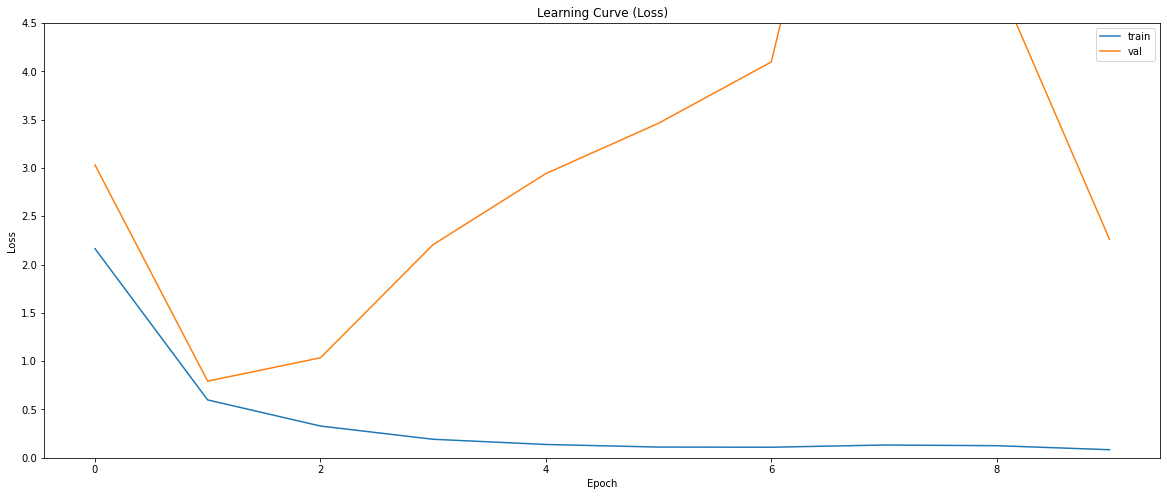

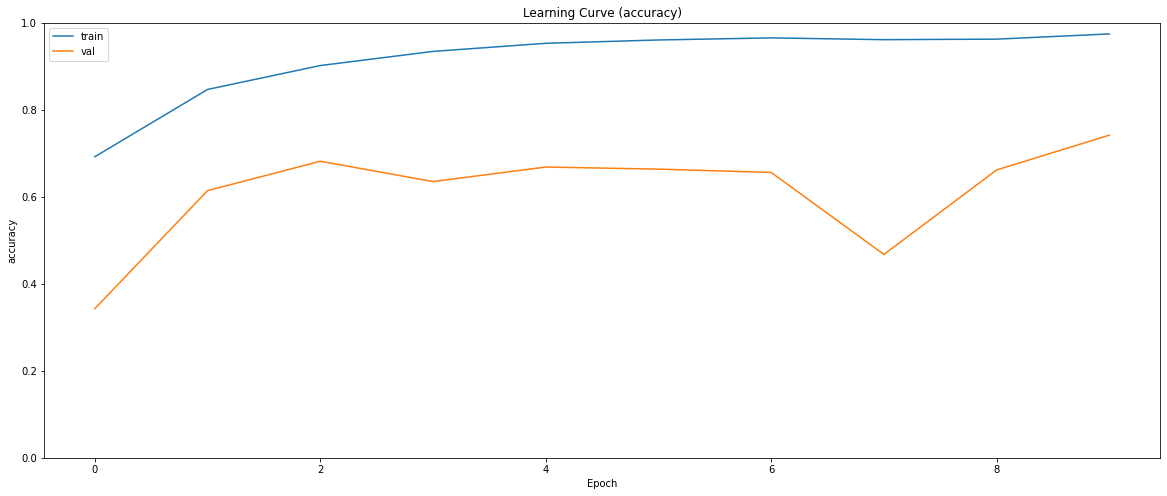

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s2.epoch, y = history_s2.history['loss'])
sns.lineplot(x = history_s2.epoch, y = history_s2.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 4.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s2.epoch, y = history_s2.history['categorical_accuracy'])
sns.lineplot(x = history_s2.epoch, y = history_s2.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()


In [ ]:
score = model_s2.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 4.43394660949707
Test accuracy: 0.6474359035491943


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_s2.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[109,  30,  95],
       [  3, 199,  40],
       [  0,  52,  96]])

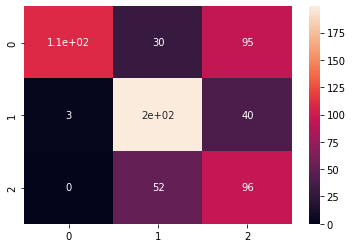

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modéle 5

In [ ]:
def get_model_s3():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

       # Block One
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)

    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(x)
    x = layers.MaxPool2D(pool_size=2)(x)



    x = layers.Flatten()(x)
    
    #Output
    output = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:


model_s3 = get_model_s3()
model_s3.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='categorical_accuracy')

model_s3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 16)      1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 46656)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1399

In [ ]:
history_s3 = model_s3.fit(x_train, y_train,
          batch_size = BATCH, epochs = 10,
          validation_data=(x_val, y_val), class_weight= class_weight);

Epoch 1/10
131/131 [==============================] - 6s 43ms/step - loss: 0.9627 - categorical_accuracy: 0.6191 - val_loss: 0.5811 - val_categorical_accuracy: 0.7448
Epoch 2/10
131/131 [==============================] - 5s 37ms/step - loss: 0.5333 - categorical_accuracy: 0.7609 - val_loss: 0.5119 - val_categorical_accuracy: 0.7724
Epoch 3/10
131/131 [==============================] - 5s 37ms/step - loss: 0.4669 - categorical_accuracy: 0.7822 - val_loss: 0.4994 - val_categorical_accuracy: 0.7705
Epoch 4/10
131/131 [==============================] - 5s 37ms/step - loss: 0.4313 - categorical_accuracy: 0.8037 - val_loss: 0.4695 - val_categorical_accuracy: 0.8114
Epoch 5/10
131/131 [==============================] - 5s 37ms/step - loss: 0.3968 - categorical_accuracy: 0.8183 - val_loss: 0.4760 - val_categorical_accuracy: 0.7990
Epoch 6/10
131/131 [==============================] - 5s 37ms/step - loss: 0.3661 - categorical_accuracy: 0.8271 - val_loss: 0.4799 - val_categorical_accuracy: 0.791

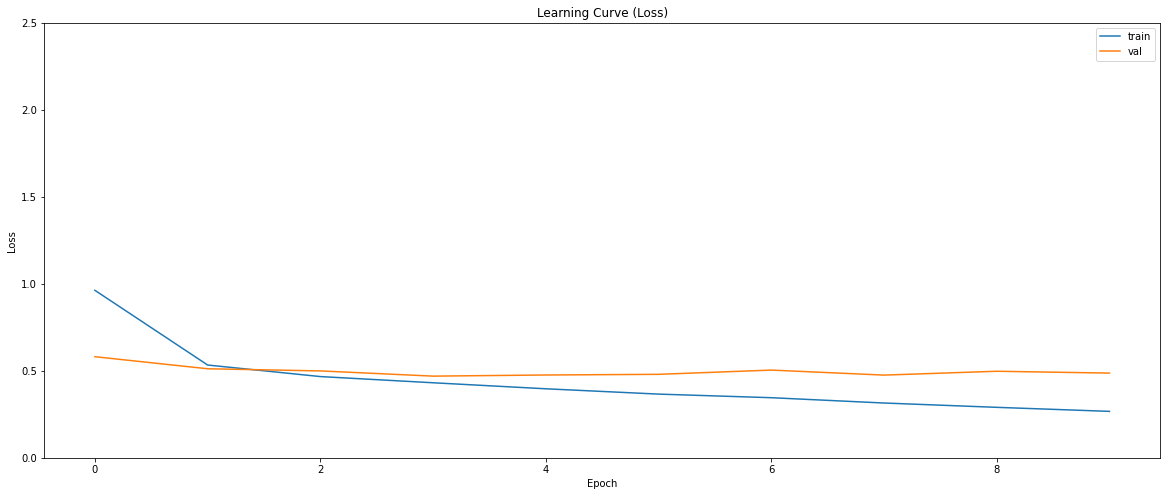

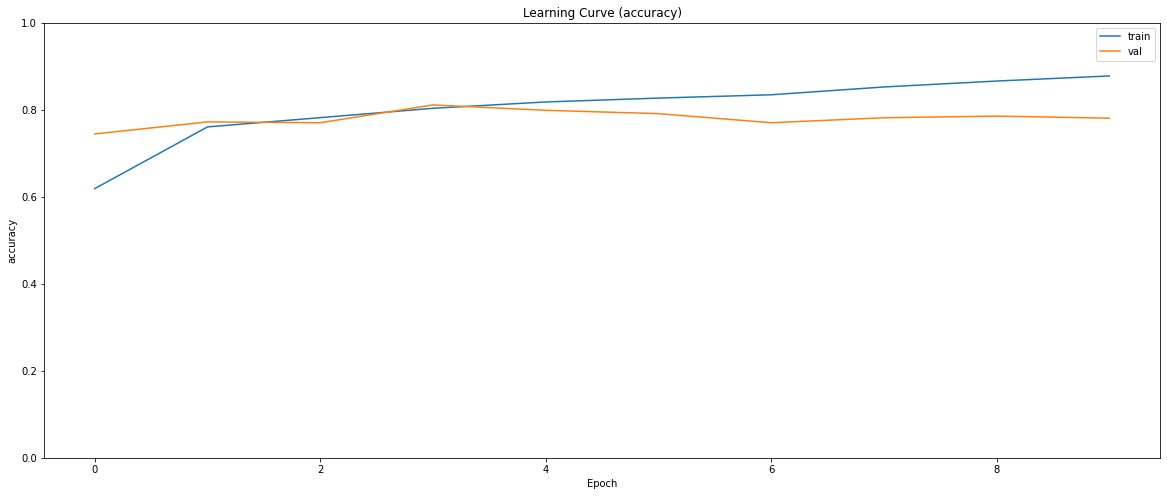

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s3.epoch, y = history_s3.history['loss'])
sns.lineplot(x = history_s3.epoch, y = history_s3.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 2.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s3.epoch, y = history_s3.history['categorical_accuracy'])
sns.lineplot(x = history_s3.epoch, y = history_s3.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_s3.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8658326864242554
Test accuracy: 0.7307692170143127


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_s3.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[124,  30,  80],
       [  1, 222,  19],
       [  0,  38, 110]])

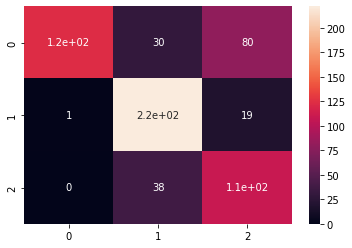

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modéle 6

In [ ]:
def get_model_s3_2():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

       # Block One
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)

    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.1)(x)


    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    
    #Output
    output = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

model_s3_2 = get_model_s3_2()
model_s3_2.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='categorical_accuracy')

model_s3_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 16)      1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 46656)             0   

In [ ]:
history_s3_2 = model_s3_2.fit(x_train, y_train,
          batch_size = BATCH, epochs = 10,
          validation_data=(x_val, y_val), class_weight= class_weight);

Epoch 1/10
131/131 [==============================] - 85s 647ms/step - loss: 0.7008 - categorical_accuracy: 0.6753 - val_loss: 0.5608 - val_categorical_accuracy: 0.7457
Epoch 2/10
131/131 [==============================] - 84s 643ms/step - loss: 0.4721 - categorical_accuracy: 0.7771 - val_loss: 0.5286 - val_categorical_accuracy: 0.7543
Epoch 3/10
131/131 [==============================] - 85s 651ms/step - loss: 0.4309 - categorical_accuracy: 0.7996 - val_loss: 0.5208 - val_categorical_accuracy: 0.7524
Epoch 4/10
131/131 [==============================] - 84s 644ms/step - loss: 0.4005 - categorical_accuracy: 0.8056 - val_loss: 0.4893 - val_categorical_accuracy: 0.7657
Epoch 5/10
131/131 [==============================] - 84s 640ms/step - loss: 0.3532 - categorical_accuracy: 0.8393 - val_loss: 0.5560 - val_categorical_accuracy: 0.7486
Epoch 6/10
131/131 [==============================] - 84s 640ms/step - loss: 0.3234 - categorical_accuracy: 0.8482 - val_loss: 0.5100 - val_categorical_acc

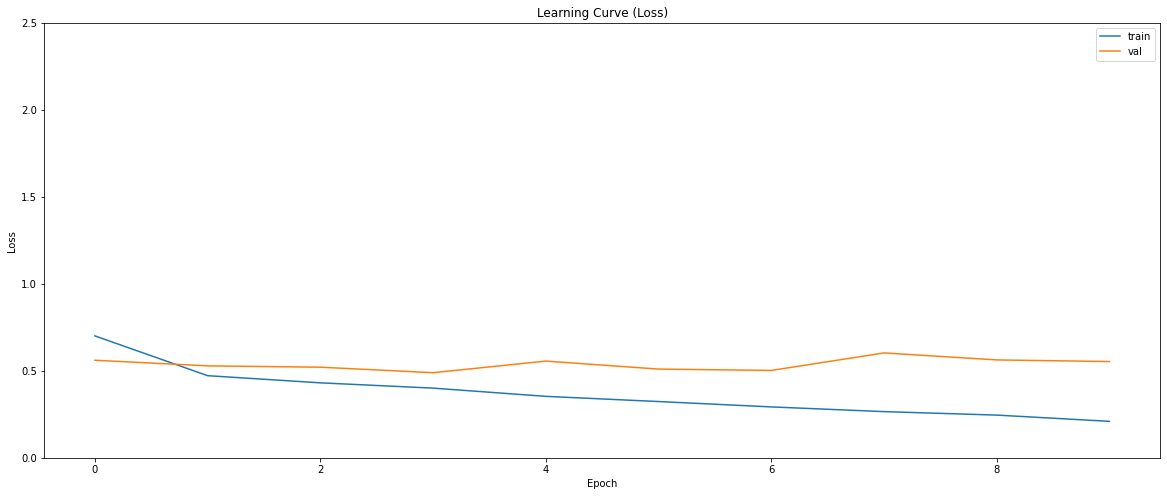

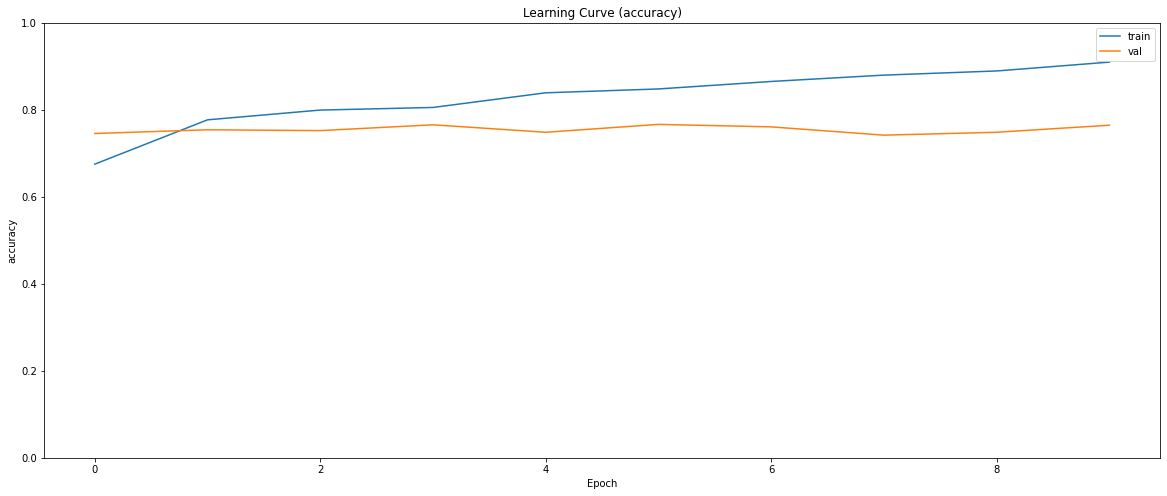

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s3_2.epoch, y = history_s3_2.history['loss'])
sns.lineplot(x = history_s3_2.epoch, y = history_s3_2.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 2.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s3_2.epoch, y = history_s3_2.history['categorical_accuracy'])
sns.lineplot(x = history_s3_2.epoch, y = history_s3_2.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_s3_2.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8383329510688782
Test accuracy: 0.7419871687889099


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_s3_2.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[145,  57,  32],
       [  1, 229,  12],
       [  2,  57,  89]])

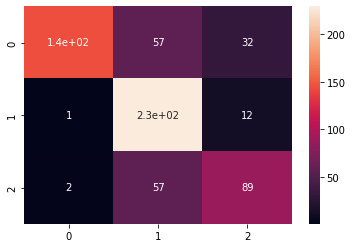

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modéle 7

In [ ]:
model_s3d = get_model_s3()
model_s3d.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='categorical_accuracy')

model_s3d.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 16)      1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 46656)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1399

In [ ]:
history_s3d = model_s3d.fit(datagen.flow(x_train, y_train),
          batch_size = BATCH, epochs = 10,
          validation_data=datagen.flow(x_val, y_val), class_weight= class_weight);

Epoch 1/10
131/131 [==============================] - 22s 164ms/step - loss: 1.0491 - categorical_accuracy: 0.5416 - val_loss: 0.7962 - val_categorical_accuracy: 0.6305
Epoch 2/10
131/131 [==============================] - 21s 161ms/step - loss: 0.7455 - categorical_accuracy: 0.6545 - val_loss: 0.9210 - val_categorical_accuracy: 0.5505
Epoch 3/10
131/131 [==============================] - 22s 167ms/step - loss: 0.7080 - categorical_accuracy: 0.6667 - val_loss: 0.6999 - val_categorical_accuracy: 0.6838
Epoch 4/10
131/131 [==============================] - 22s 167ms/step - loss: 0.6680 - categorical_accuracy: 0.6911 - val_loss: 0.6748 - val_categorical_accuracy: 0.6905
Epoch 5/10
131/131 [==============================] - 22s 166ms/step - loss: 0.6534 - categorical_accuracy: 0.6913 - val_loss: 0.6346 - val_categorical_accuracy: 0.7152
Epoch 6/10
131/131 [==============================] - 22s 166ms/step - loss: 0.6414 - categorical_accuracy: 0.6954 - val_loss: 0.6180 - val_categorical_acc

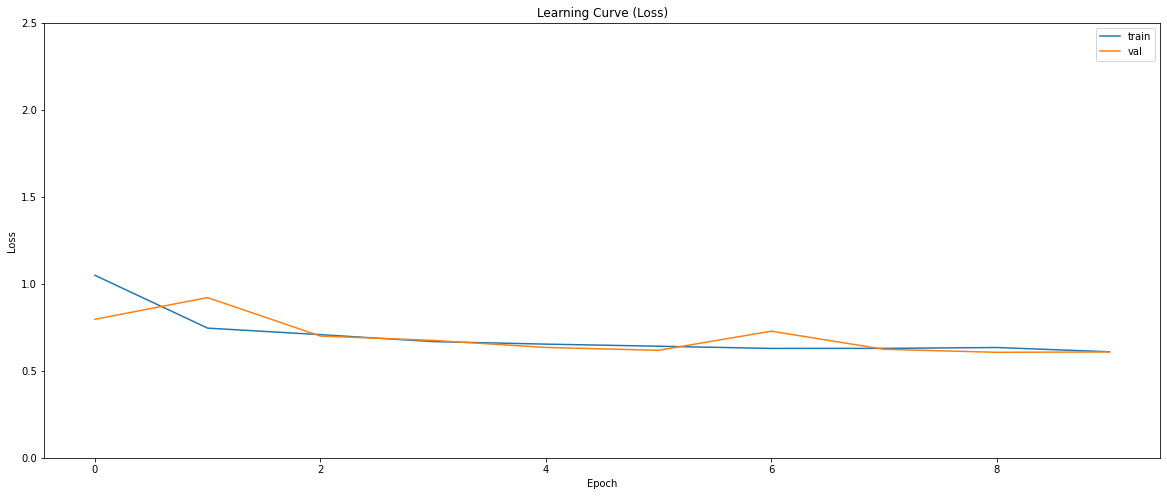

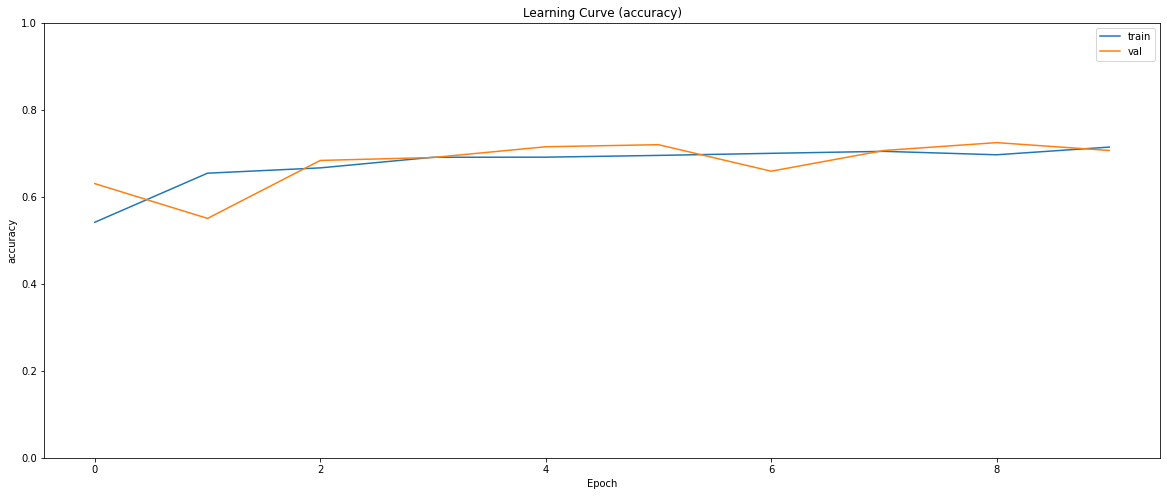

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s3d.epoch, y = history_s3d.history['loss'])
sns.lineplot(x = history_s3d.epoch, y = history_s3d.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 2.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s3d.epoch, y = history_s3d.history['categorical_accuracy'])
sns.lineplot(x = history_s3d.epoch, y = history_s3d.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_s3d.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.48440948128700256
Test accuracy: 0.8157051205635071


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_s3d.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[198,  11,  25],
       [ 20, 184,  38],
       [  8,  13, 127]])

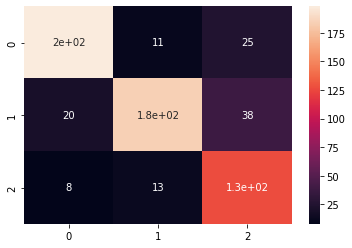

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modéle 8

In [ ]:
def get_model_s3b():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

       # Block One
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)

    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(x)
    x = layers.MaxPool2D(pool_size=2)(x)


    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    
    #Output
    output = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:

model_s3db = get_model_s3b()
model_s3db.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='categorical_accuracy')

model_s3db.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 109, 109, 16)      1168      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 46656)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 46656)             186

In [ ]:
history_s3db = model_s3db.fit(datagen.flow(x_train, y_train),
          batch_size = BATCH, epochs = 20,
          callbacks=[early_stopping, plateau],
          validation_data=datagen.flow(x_val, y_val), class_weight= class_weight);

Epoch 1/20
131/131 [==============================] - 22s 164ms/step - loss: 1.7568 - categorical_accuracy: 0.5803 - val_loss: 1.4662 - val_categorical_accuracy: 0.4038
Epoch 2/20
131/131 [==============================] - 21s 162ms/step - loss: 0.9647 - categorical_accuracy: 0.6389 - val_loss: 1.7652 - val_categorical_accuracy: 0.3390
Epoch 3/20
131/131 [==============================] - 21s 162ms/step - loss: 0.7970 - categorical_accuracy: 0.6593 - val_loss: 0.9986 - val_categorical_accuracy: 0.4800
Epoch 4/20
131/131 [==============================] - 22s 166ms/step - loss: 0.7291 - categorical_accuracy: 0.6674 - val_loss: 1.7727 - val_categorical_accuracy: 0.3467
Epoch 5/20
131/131 [==============================] - 22s 168ms/step - loss: 0.7545 - categorical_accuracy: 0.6566 - val_loss: 0.8955 - val_categorical_accuracy: 0.6038
Epoch 6/20
131/131 [==============================] - 22s 165ms/step - loss: 0.6815 - categorical_accuracy: 0.6777 - val_loss: 1.9850 - val_categorical_acc

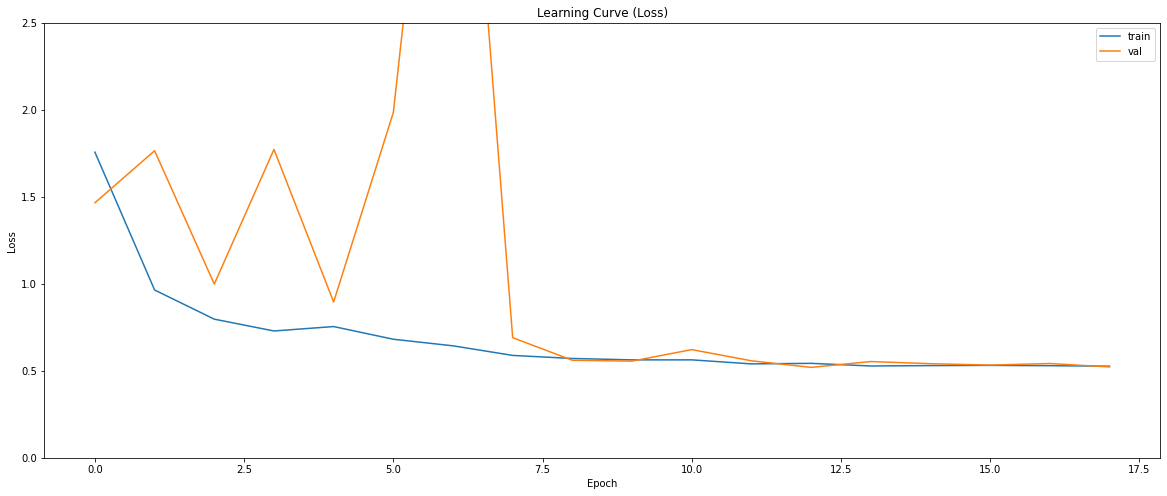

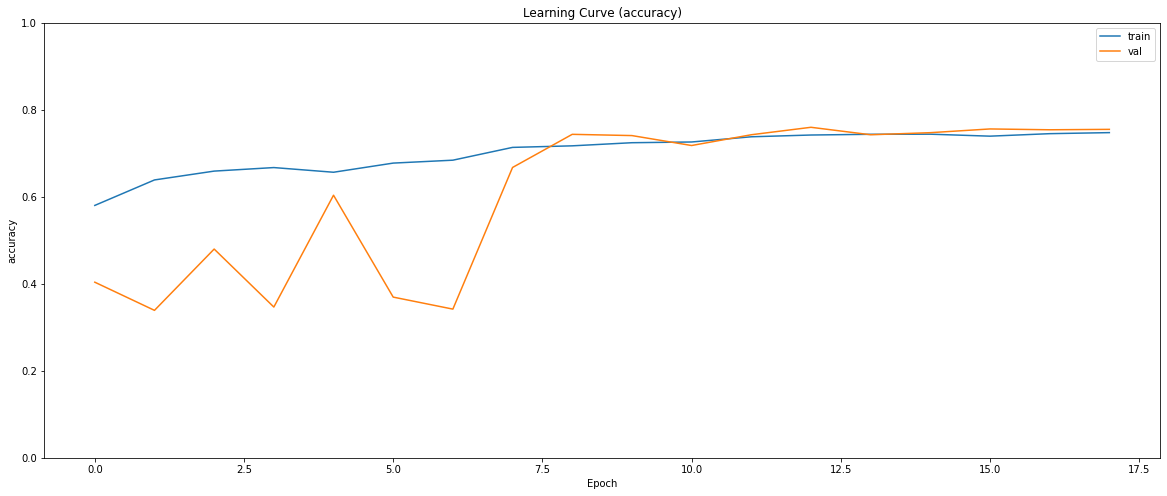

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s3db.epoch, y = history_s3db.history['loss'])
sns.lineplot(x = history_s3db.epoch, y = history_s3db.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 2.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s3db.epoch, y = history_s3db.history['categorical_accuracy'])
sns.lineplot(x = history_s3db.epoch, y = history_s3db.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_s3db.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.40916091203689575
Test accuracy: 0.8717948794364929


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_s3db.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[219,   3,  12],
       [ 23, 202,  17],
       [  7,  18, 123]])

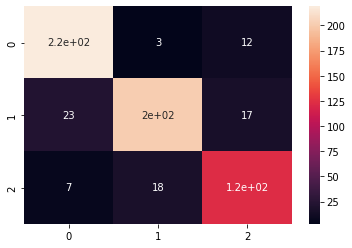

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modéle 9

In [ ]:
def get_model_s4():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

       # Block One
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)

    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(x)
    x = layers.MaxPool2D(pool_size=2)(x)


    
    x = layers.Flatten()(x)
    
    #Output
    output = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:

model_s4 = get_model_s4()
model_s4.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='categorical_accuracy')

model_s4.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 8)       584       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 8)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 23328)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 6998

In [ ]:
history_s4 = model_s4.fit(x_train, y_train,
          batch_size = BATCH, epochs = 10,
          validation_data=(x_val, y_val), class_weight= class_weight);

Epoch 1/10
131/131 [==============================] - 5s 37ms/step - loss: 0.8261 - categorical_accuracy: 0.6423 - val_loss: 0.6129 - val_categorical_accuracy: 0.7333
Epoch 2/10
131/131 [==============================] - 4s 34ms/step - loss: 0.5298 - categorical_accuracy: 0.7635 - val_loss: 0.5447 - val_categorical_accuracy: 0.7638
Epoch 3/10
131/131 [==============================] - 4s 34ms/step - loss: 0.4700 - categorical_accuracy: 0.7774 - val_loss: 0.5036 - val_categorical_accuracy: 0.7857
Epoch 4/10
131/131 [==============================] - 4s 34ms/step - loss: 0.4221 - categorical_accuracy: 0.7984 - val_loss: 0.5072 - val_categorical_accuracy: 0.7810
Epoch 5/10
131/131 [==============================] - 4s 34ms/step - loss: 0.3913 - categorical_accuracy: 0.8144 - val_loss: 0.5257 - val_categorical_accuracy: 0.7714
Epoch 6/10
131/131 [==============================] - 4s 34ms/step - loss: 0.3494 - categorical_accuracy: 0.8326 - val_loss: 0.4915 - val_categorical_accuracy: 0.785

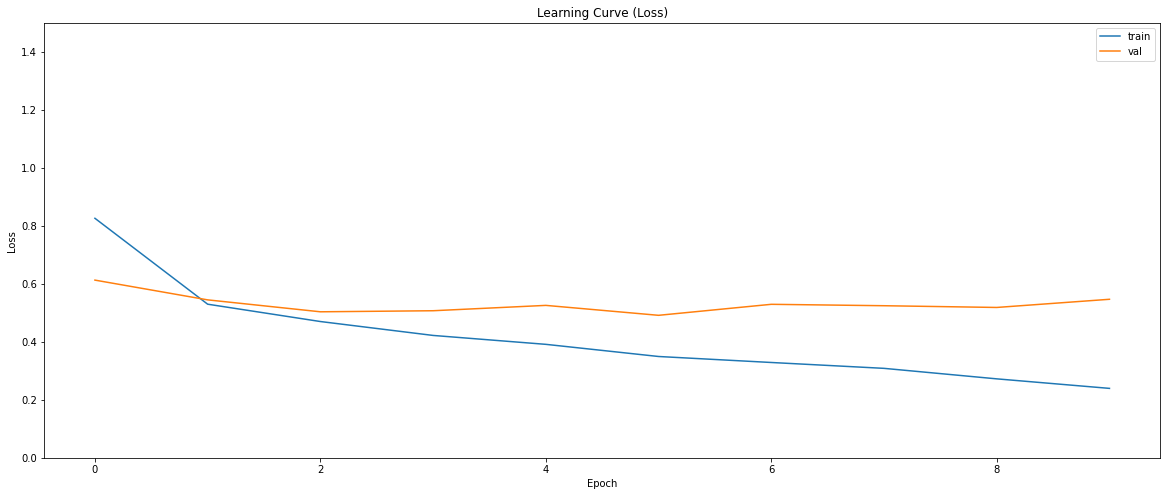

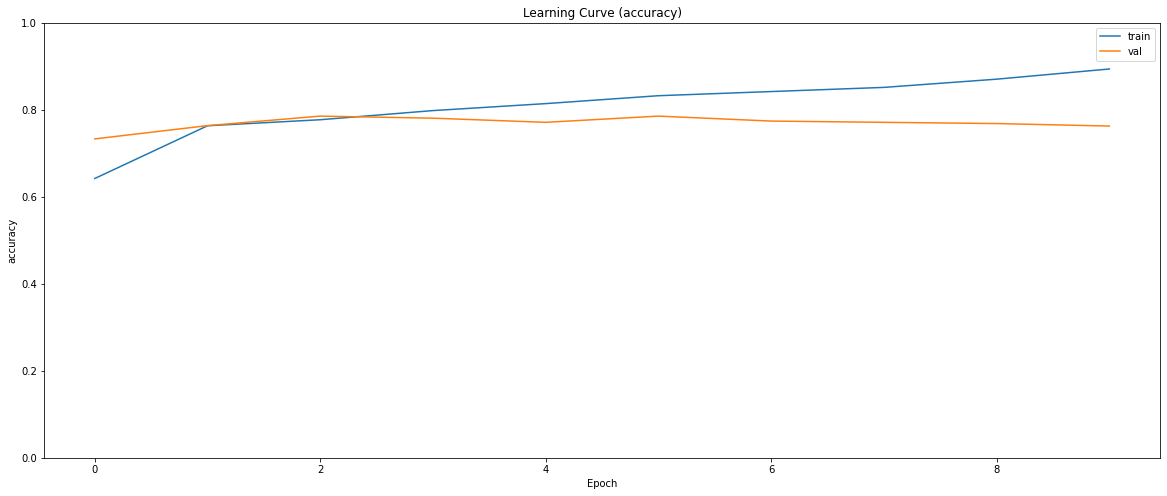

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s4.epoch, y = history_s4.history['loss'])
sns.lineplot(x = history_s4.epoch, y = history_s4.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s4.epoch, y = history_s4.history['categorical_accuracy'])
sns.lineplot(x = history_s4.epoch, y = history_s4.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_s4.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9454444646835327
Test accuracy: 0.7131410241127014


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_s4.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[122,  56,  56],
       [  1, 217,  24],
       [  1,  41, 106]])

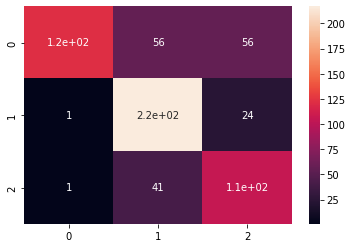

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modéle 10

In [ ]:
def get_model_s5():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

       # Block One
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)


    
    x = layers.Flatten()(x)

    #Output
    output = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:

model_s5 = get_model_s5()
model_s5.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='categorical_accuracy')

model_s5.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 111, 111, 8)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 16)      1168      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 54, 54, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 54, 54, 16)        0   

In [ ]:
history_s5 = model_s5.fit(x_train, y_train,
          batch_size = BATCH, epochs = 10,
          callbacks=[early_stopping],
          validation_data=(x_val, y_val), class_weight= class_weight);

Epoch 1/10
131/131 [==============================] - 6s 43ms/step - loss: 0.9110 - categorical_accuracy: 0.6098 - val_loss: 0.6991 - val_categorical_accuracy: 0.6733
Epoch 2/10
131/131 [==============================] - 5s 40ms/step - loss: 0.5449 - categorical_accuracy: 0.7461 - val_loss: 0.5513 - val_categorical_accuracy: 0.7610
Epoch 3/10
131/131 [==============================] - 5s 40ms/step - loss: 0.4838 - categorical_accuracy: 0.7719 - val_loss: 0.5147 - val_categorical_accuracy: 0.7686
Epoch 4/10
131/131 [==============================] - 5s 40ms/step - loss: 0.4523 - categorical_accuracy: 0.7834 - val_loss: 0.5215 - val_categorical_accuracy: 0.7505
Epoch 5/10
131/131 [==============================] - 5s 40ms/step - loss: 0.4390 - categorical_accuracy: 0.7881 - val_loss: 0.6313 - val_categorical_accuracy: 0.7095
Epoch 6/10
131/131 [==============================] - 5s 40ms/step - loss: 0.4105 - categorical_accuracy: 0.8027 - val_loss: 0.5366 - val_categorical_accuracy: 0.741

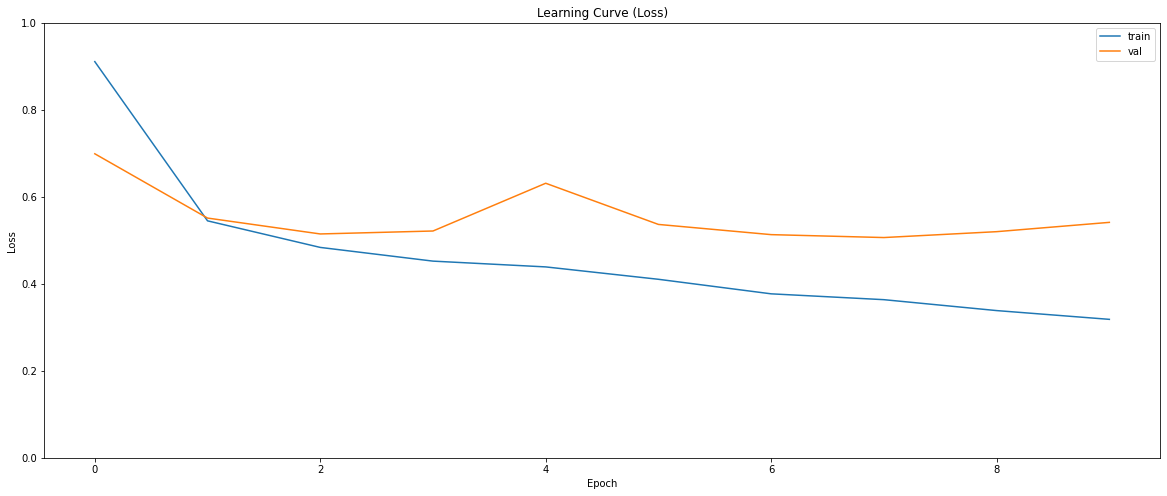

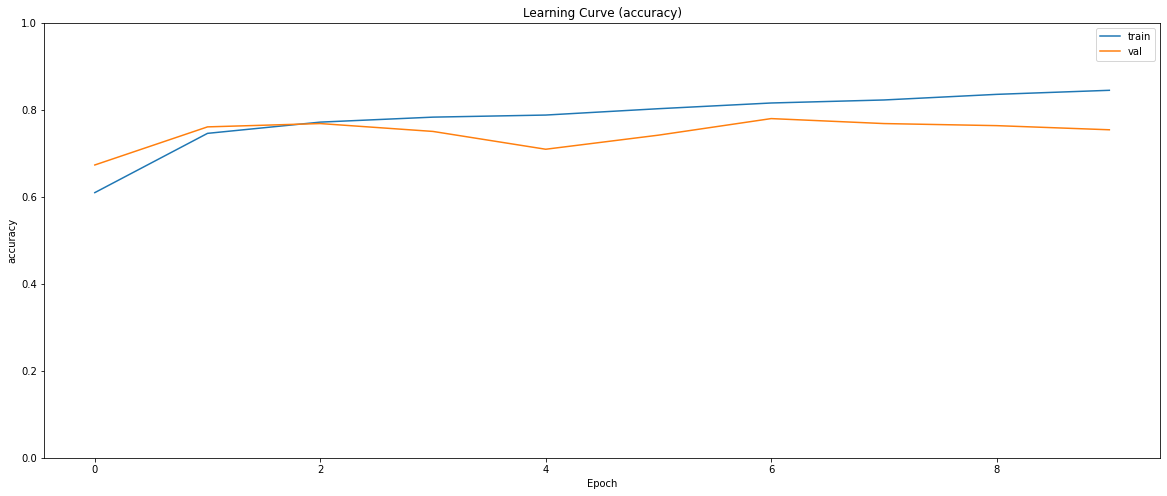

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s5.epoch, y = history_s5.history['loss'])
sns.lineplot(x = history_s5.epoch, y = history_s5.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s5.epoch, y = history_s5.history['categorical_accuracy'])
sns.lineplot(x = history_s5.epoch, y = history_s5.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_s5.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9094359278678894
Test accuracy: 0.7131410241127014


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_s5.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[114,  39,  81],
       [  1, 205,  36],
       [  0,  22, 126]])

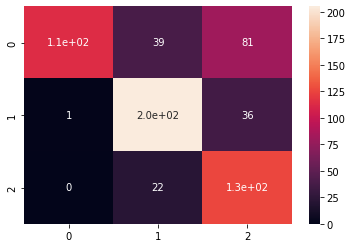

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modéle 11

In [ ]:
def get_model_s6():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

       # Block One
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.1)(x)


    
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)

    #Output
    output = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:

model_s6 = get_model_s6()
model_s6.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='categorical_accuracy')

model_s6.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 111, 111, 8)       0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 109, 109, 16)      1168      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 54, 54, 16)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 54, 54, 16)        0  

In [ ]:
history_s6 = model_s6.fit(x_train, y_train,
          batch_size = BATCH, epochs = 20,
          
          validation_data=(x_val, y_val), class_weight= class_weight);

Epoch 1/20
131/131 [==============================] - 6s 44ms/step - loss: 0.7809 - categorical_accuracy: 0.6131 - val_loss: 0.5945 - val_categorical_accuracy: 0.7390
Epoch 2/20
131/131 [==============================] - 5s 41ms/step - loss: 0.5316 - categorical_accuracy: 0.7427 - val_loss: 0.5191 - val_categorical_accuracy: 0.7362
Epoch 3/20
131/131 [==============================] - 5s 41ms/step - loss: 0.4741 - categorical_accuracy: 0.7702 - val_loss: 0.5218 - val_categorical_accuracy: 0.7571
Epoch 4/20
131/131 [==============================] - 5s 41ms/step - loss: 0.4478 - categorical_accuracy: 0.7738 - val_loss: 0.5722 - val_categorical_accuracy: 0.7314
Epoch 5/20
131/131 [==============================] - 5s 41ms/step - loss: 0.4145 - categorical_accuracy: 0.7953 - val_loss: 0.5633 - val_categorical_accuracy: 0.7543
Epoch 6/20
131/131 [==============================] - 5s 41ms/step - loss: 0.4004 - categorical_accuracy: 0.8032 - val_loss: 0.4760 - val_categorical_accuracy: 0.777

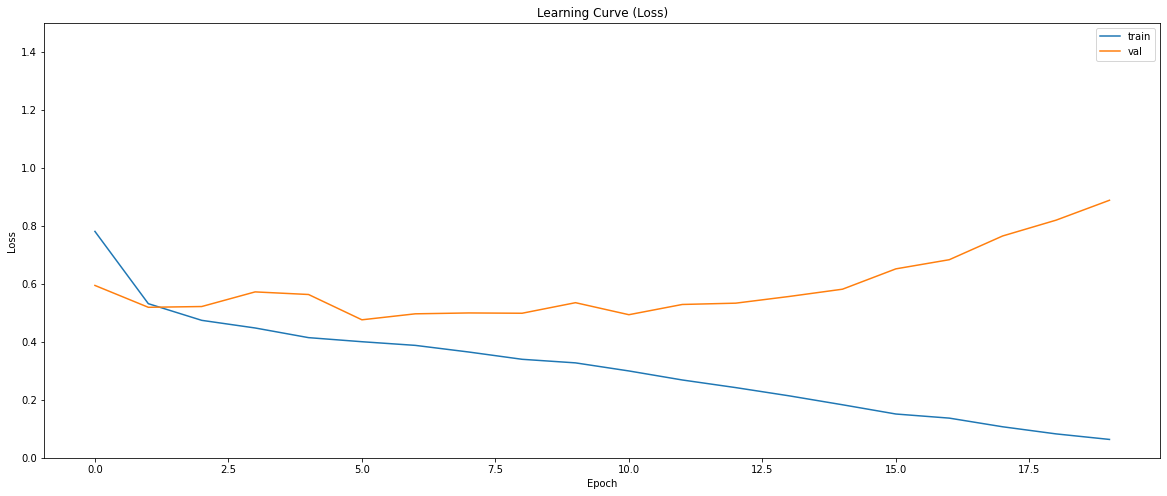

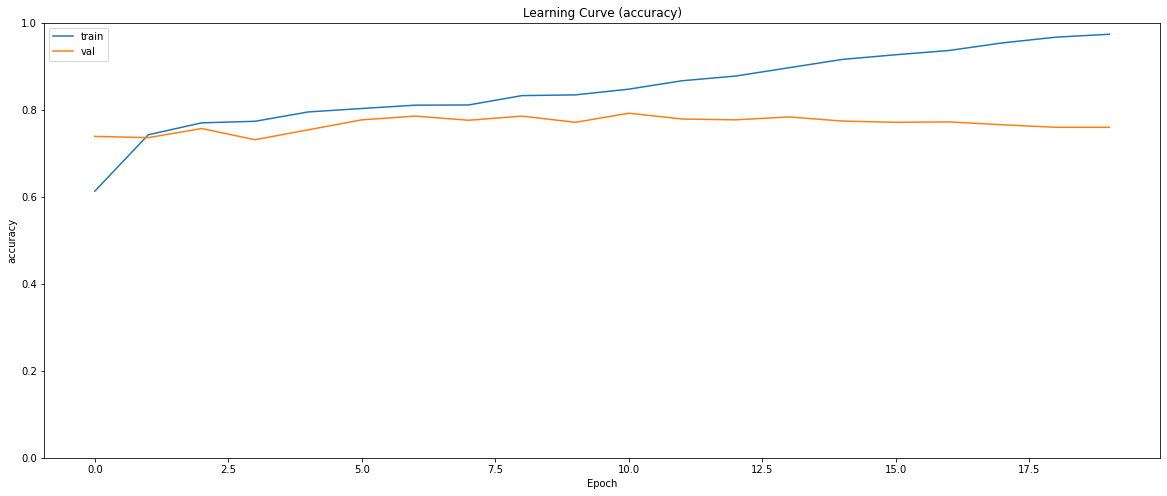

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s6.epoch, y = history_s6.history['loss'])
sns.lineplot(x = history_s6.epoch, y = history_s6.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s6.epoch, y = history_s6.history['categorical_accuracy'])
sns.lineplot(x = history_s6.epoch, y = history_s6.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_s6.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5142592191696167
Test accuracy: 0.7339743375778198


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_s6.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[134,  33,  67],
       [  4, 220,  18],
       [  1,  43, 104]])

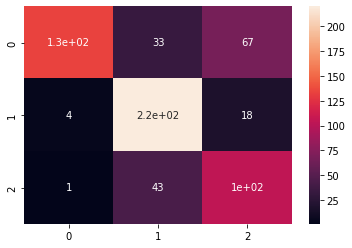

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modéle 12

In [ ]:
def get_model_s7():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

       # Block One
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid', activation='relu')(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.1)(x)


    
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)

    #Output
    output = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:

model_s7 = get_model_s7()
model_s7.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='categorical_accuracy')

model_s7.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 111, 111, 8)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 109, 109, 16)      1168      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 54, 54, 16)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 54, 54, 16)        0  

In [ ]:
history_s7 = model_s7.fit(x_train, y_train,
          batch_size = BATCH, epochs = 15,
          validation_data=(x_val, y_val), class_weight= class_weight);

Epoch 1/15
131/131 [==============================] - 7s 46ms/step - loss: 0.9180 - categorical_accuracy: 0.4620 - val_loss: 0.7525 - val_categorical_accuracy: 0.5829
Epoch 2/15
131/131 [==============================] - 6s 43ms/step - loss: 0.6333 - categorical_accuracy: 0.5949 - val_loss: 0.6199 - val_categorical_accuracy: 0.6990
Epoch 3/15
131/131 [==============================] - 6s 43ms/step - loss: 0.5614 - categorical_accuracy: 0.6973 - val_loss: 0.5825 - val_categorical_accuracy: 0.7143
Epoch 4/15
131/131 [==============================] - 6s 43ms/step - loss: 0.5028 - categorical_accuracy: 0.7446 - val_loss: 0.5542 - val_categorical_accuracy: 0.7438
Epoch 5/15
131/131 [==============================] - 6s 43ms/step - loss: 0.4700 - categorical_accuracy: 0.7582 - val_loss: 0.5486 - val_categorical_accuracy: 0.7248
Epoch 6/15
131/131 [==============================] - 6s 43ms/step - loss: 0.4531 - categorical_accuracy: 0.7685 - val_loss: 0.5423 - val_categorical_accuracy: 0.748

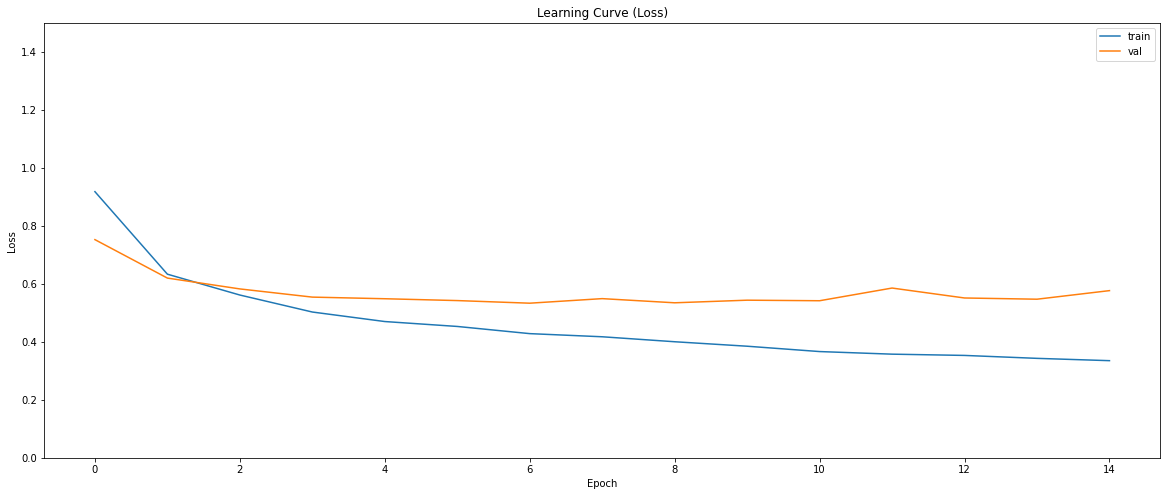

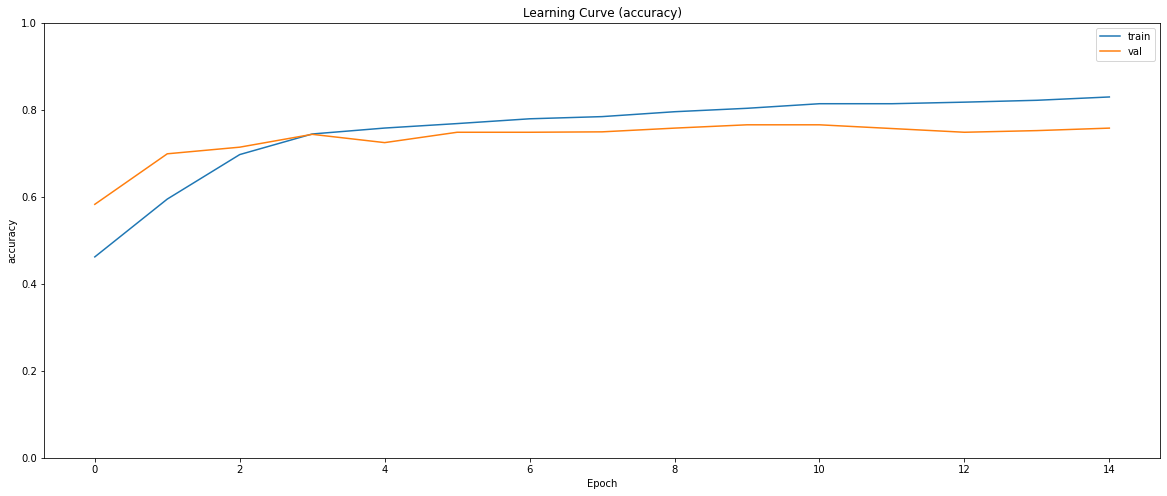

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s7.epoch, y = history_s7.history['loss'])
sns.lineplot(x = history_s7.epoch, y = history_s7.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s7.epoch, y = history_s7.history['categorical_accuracy'])
sns.lineplot(x = history_s7.epoch, y = history_s7.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_s7.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.158412218093872
Test accuracy: 0.7660256624221802


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_s7.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[129,  59,  46],
       [  2, 222,  18],
       [  1,  20, 127]])

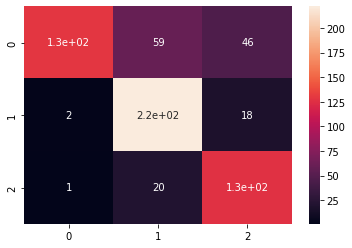

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modéle 13

In [ ]:
def get_model_s9():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

       # Block One
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)


    
    x = layers.Flatten()(x)

    #Output
    output = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:
model_s9 = get_model_s9()
model_s9.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(0.0003), metrics='categorical_accuracy')

model_s9.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 222, 222, 8)       80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 8)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 111, 111, 8)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 98568)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 295707    
Total params: 295,787
Trainable params: 295,787
Non-trainable params: 0
_____________________________________________________

In [ ]:
history_s9 = model_s9.fit(x_train, y_train,
          batch_size = BATCH, epochs = 10,
          validation_data=(x_val, y_val),
          callbacks=[early_stopping, plateau], 
          class_weight= class_weight);

Epoch 1/10
131/131 [==============================] - 59s 448ms/step - loss: 1.0325 - categorical_accuracy: 0.5858 - val_loss: 0.6297 - val_categorical_accuracy: 0.7229
Epoch 2/10
131/131 [==============================] - 59s 450ms/step - loss: 0.6645 - categorical_accuracy: 0.6870 - val_loss: 0.6960 - val_categorical_accuracy: 0.6657
Epoch 3/10
131/131 [==============================] - 58s 445ms/step - loss: 0.5815 - categorical_accuracy: 0.7248 - val_loss: 0.5110 - val_categorical_accuracy: 0.7733
Epoch 4/10
131/131 [==============================] - 58s 446ms/step - loss: 0.5309 - categorical_accuracy: 0.7496 - val_loss: 0.5827 - val_categorical_accuracy: 0.7276
Epoch 5/10
131/131 [==============================] - 59s 450ms/step - loss: 0.5159 - categorical_accuracy: 0.7496 - val_loss: 0.5450 - val_categorical_accuracy: 0.7457

Epoch 00005: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
Epoch 6/10
131/131 [==============================] - 58s 445ms/step - los

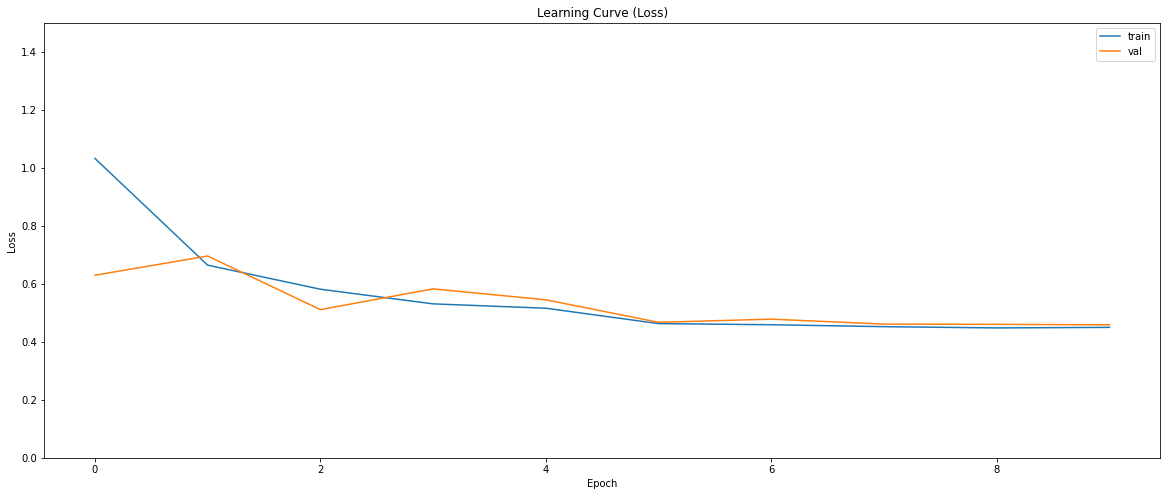

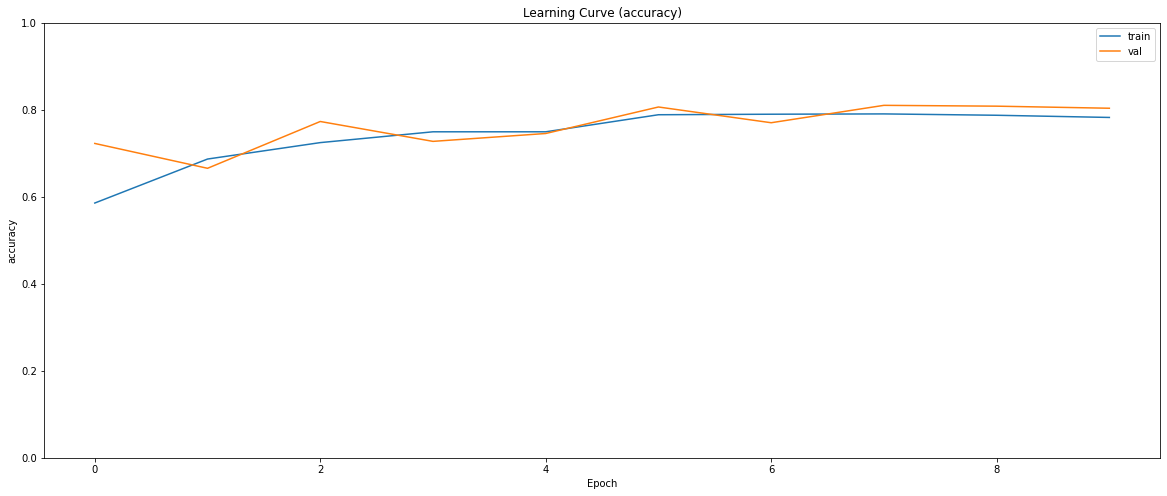

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s9.epoch, y = history_s9.history['loss'])
sns.lineplot(x = history_s9.epoch, y = history_s9.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history_s9.epoch, y = history_s9.history['categorical_accuracy'])
sns.lineplot(x = history_s9.epoch, y = history_s9.history['val_categorical_accuracy'])
ax.set_title('Learning Curve (accuracy)')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_s9.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5872281193733215
Test accuracy: 0.8028846383094788


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model_s9.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[160,  24,  50],
       [  4, 219,  19],
       [  3,  23, 122]])

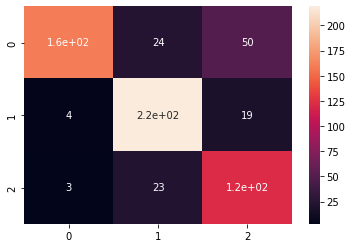

In [ ]:
sns.heatmap(table, annot=True)
plt.show()

### modèle 14

In [ ]:
def get_model3():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

       # Block One
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(inputs)
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)



    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    
    #Output
    output = layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:
keras.backend.clear_session()

model3 = get_model3()
model3.compile(loss='categorical_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='categorical_accuracy')

model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 8)       80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 16)      1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 16)      2320  

In [ ]:
history3 = model3.fit(x_train, y_train,
          batch_size = BATCH, epochs = 10,
          validation_data=(x_val, y_val),
          class_weight= class_weight);

Epoch 1/10
131/131 [==============================] - 230s 2s/step - loss: 0.9518 - categorical_accuracy: 0.5634 - val_loss: 0.7263 - val_categorical_accuracy: 0.6686
Epoch 2/10
131/131 [==============================] - 228s 2s/step - loss: 0.6693 - categorical_accuracy: 0.6774 - val_loss: 0.6724 - val_categorical_accuracy: 0.6838
Epoch 3/10
131/131 [==============================] - 233s 2s/step - loss: 0.5950 - categorical_accuracy: 0.7186 - val_loss: 0.7109 - val_categorical_accuracy: 0.6933
Epoch 4/10
131/131 [==============================] - 229s 2s/step - loss: 0.5812 - categorical_accuracy: 0.7154 - val_loss: 0.5940 - val_categorical_accuracy: 0.7152
Epoch 5/10
131/131 [==============================] - 228s 2s/step - loss: 0.5576 - categorical_accuracy: 0.7284 - val_loss: 0.6313 - val_categorical_accuracy: 0.6943
Epoch 6/10
131/131 [==============================] - 231s 2s/step - loss: 0.5283 - categorical_accuracy: 0.7437 - val_loss: 0.6065 - val_categorical_accuracy: 0.710

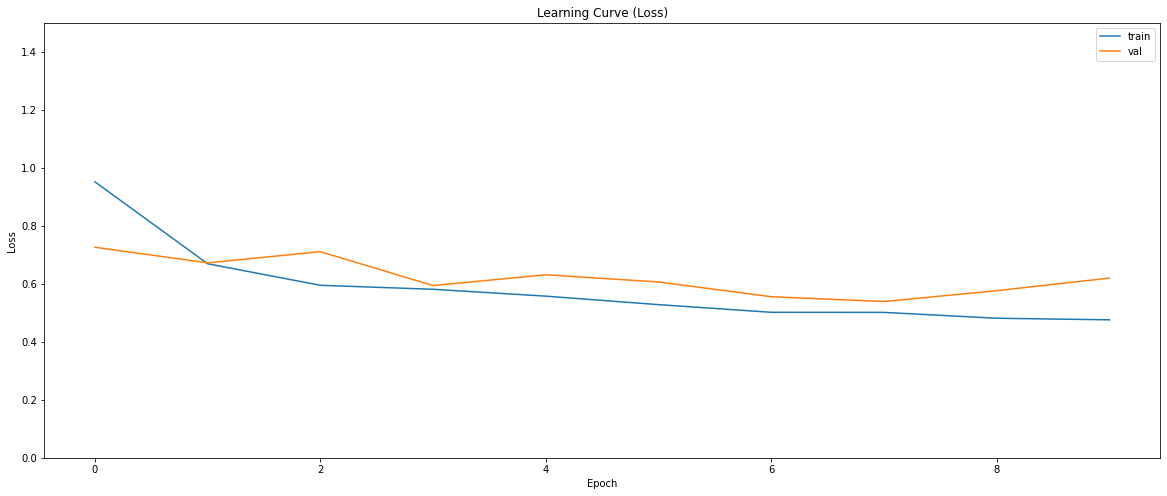

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history3.epoch, y = history3.history['loss'])
sns.lineplot(x = history3.epoch, y = history3.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model3.evaluate(x_test,y_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9031341671943665
Test accuracy: 0.7147436141967773


In [ ]:
from sklearn.metrics import confusion_matrix
predic= model3.predict(x_test)
table=metrics.confusion_matrix(y_test.argmax(axis=1), predic.argmax(axis=1))
table

array([[136,  13,  85],
       [  1, 205,  36],
       [  2,  41, 105]])

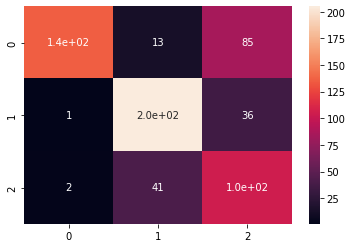

In [ ]:
sns.heatmap(table, annot=True)
plt.show()